<a href="https://colab.research.google.com/github/vamsigp/EIP-4/blob/master/Wk-5/W5_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls

replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/  hvc_annotations.csv  model_plot.png  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
import numpy as np

from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

In [0]:
one_hot_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg,resized/6.jpg,resized/7.jpg,resized/8.jpg,resized/9.jpg,resized/10.jpg
gender_female,0,1,0,0,1,0,0,0,0,0
gender_male,1,0,1,1,0,1,1,1,1,1
imagequality_Average,1,1,0,0,0,0,0,0,1,1
imagequality_Bad,0,0,0,0,0,0,1,0,0,0
imagequality_Good,0,0,1,1,1,1,0,1,0,0
age_15-25,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,0,0,0,0,1,1,0,1
age_35-45,1,1,0,0,1,1,0,0,1,0
age_45-55,0,0,1,1,0,0,0,0,0,0


In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
col_list = [_gender_cols_, _imagequality_cols_, _age_cols_, _weight_cols_, _carryingbag_cols_, _footwear_cols_, _emotion_cols_, _bodypose_cols_]

In [0]:
for row in (col_list):
  print(row)

['gender_female', 'gender_male']
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
['bodypose_Back', 'bodypose_Front-Frontish', 'bodypose_Side']


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    image_aug = False

    def __init__(self, df, batch_size=32, shuffle=True, image_aug=False):
        self.image_aug = image_aug
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        if self.image_aug:
          eraser = get_random_eraser()
          aug_image_stack = np.stack([eraser(img) for img in image])

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        if self.image_aug:
          return aug_image_stack, target

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
4857,resized/4858.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
5326,resized/5327.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
1211,resized/1212.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
870,resized/871.jpg,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
11316,resized/11318.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11537 entries, 4857 to 2446
Data columns (total 28 columns):
image_path                              11537 non-null object
gender_female                           11537 non-null uint8
gender_male                             11537 non-null uint8
imagequality_Average                    11537 non-null uint8
imagequality_Bad                        11537 non-null uint8
imagequality_Good                       11537 non-null uint8
age_15-25                               11537 non-null uint8
age_25-35                               11537 non-null uint8
age_35-45                               11537 non-null uint8
age_45-55                               11537 non-null uint8
age_55+                                 11537 non-null uint8
weight_normal-healthy                   11537 non-null uint8
weight_over-weight                      11537 non-null uint8
weight_slightly-overweight              11537 non-null uint8
weight_underweight                

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, image_aug=True)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False, image_aug=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
len(images)

32

In [0]:
images[0].shape

(224, 224, 3)

In [0]:
# plt.imshow(images[0])
for key in targets.keys():
  targets.get('key')

In [0]:
targets.get('gender_output')[0]

array([1, 0], dtype=uint8)

In [0]:
import matplotlib.pyplot as plt

plt.clf()
plt.style.use('seaborn-muted')

<Figure size 432x288 with 0 Axes>

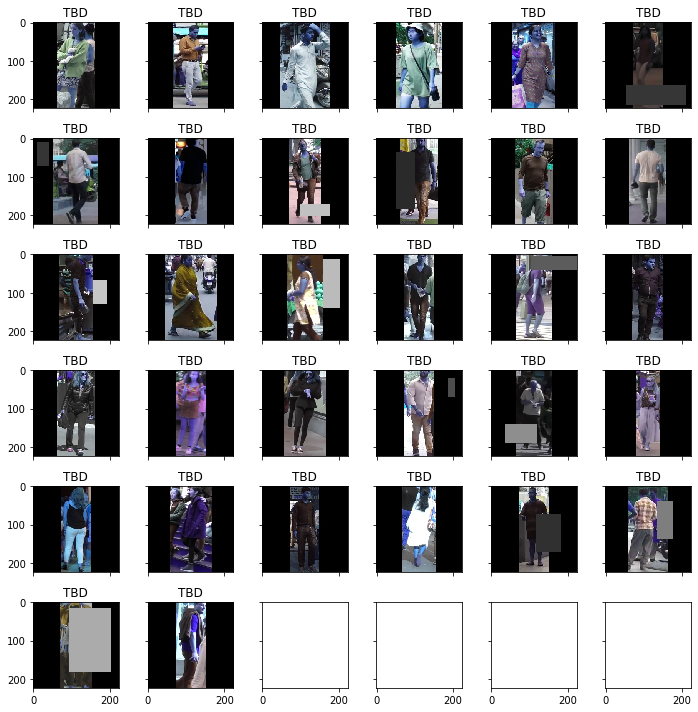

In [0]:
fig, axes = plt.subplots(6,6, figsize=(10,10),sharex=True, sharey=True, subplot_kw=dict(adjustable='box', aspect='equal'))

for i in range(len(images)):
  subplot_row = i//6
  subplot_col = i%6 
  ax = axes[subplot_row, subplot_col]
  ax.imshow(images[i], cmap='gray_r')
  ax.set_title('TBD')

plt.tight_layout()
plt.show()

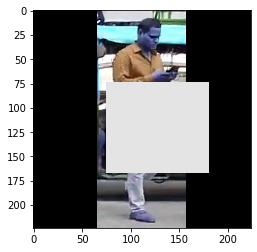

In [0]:
test_image = images[1]
eraser = get_random_eraser(pixel_level=False)
eraser(test_image)
plt.imshow(test_image)

### Model Creation - VGG16

In [0]:
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

# backbone = VGG16(
#     weights=None, 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)
#vk
neck = BatchNormalization()(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    return neck


def build_head(name, in_layer):
    x = Dense(num_units[name], activation="softmax", name=f"{name}_output")(in_layer)
    # return BatchNormalization()(x)
    return x

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
# freeze backbone
# VK
for layer in backbone.layers:
	layer.trainable = False

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output_acc": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
train_history = model.fit_generator(generator=train_gen, validation_data=valid_gen, use_multiprocessing=True, 
                                    workers=6, epochs=30,verbose=1)

Epoch 1/30
360/360 [==============================] - 133s 368ms/step - loss: 7.9018 - gender_output_loss: 0.4949 - image_quality_output_loss: 1.0220 - age_output_loss: 1.5773 - weight_output_loss: 1.1460 - bag_output_loss: 0.9778 - footwear_output_loss: 0.8831 - pose_output_loss: 0.7413 - emotion_output_loss: 1.0594 - gender_output_acc: 0.7664 - image_quality_output_acc: 0.5020 - age_output_acc: 0.3395 - weight_output_acc: 0.5532 - bag_output_acc: 0.5527 - footwear_output_acc: 0.6152 - pose_output_acc: 0.6835 - emotion_output_acc: 0.6206 - val_loss: 7.1535 - val_gender_output_loss: 0.4225 - val_image_quality_output_loss: 0.9548 - val_age_output_loss: 1.4637 - val_weight_output_loss: 1.0562 - val_bag_output_loss: 0.8947 - val_footwear_output_loss: 0.7924 - val_pose_output_loss: 0.6052 - val_emotion_output_loss: 0.9640 - val_gender_output_acc: 0.8090 - val_image_quality_output_acc: 0.5625 - val_age_output_acc: 0.3493 - val_weight_output_acc: 0.6089 - val_bag_output_acc: 0.5907 - val_foo

In [0]:
s3 = "gender_output_loss: 0.2091 - image_quality_output_loss: 0.4659 - age_output_loss: 0.6375 - weight_output_loss: 0.4309 - bag_output_loss: 0.3924 - footwear_output_loss: 0.3860 - pose_output_loss: 0.2568 - emotion_output_loss: 0.3957 - gender_output_acc: 0.9141 - image_quality_output_acc: 0.8069 - age_output_acc: 0.7595 - weight_output_acc: 0.8389 - bag_output_acc: 0.8430 - footwear_output_acc: 0.8431 - pose_output_acc: 0.9009 - emotion_output_acc: 0.8589 - val_loss: 9.5699 - val_gender_output_loss: 0.4807 - val_image_quality_output_loss: 1.3164 - val_age_output_loss: 1.9510 - val_weight_output_loss: 1.4516 - val_bag_output_loss: 1.2261 - val_footwear_output_loss: 1.0684 - val_pose_output_loss: 0.6819 - val_emotion_output_loss: 1.3939 - val_gender_output_acc: 0.8382 - val_image_quality_output_acc: 0.5010 - val_age_output_acc: 0.3584 - val_weight_output_acc: 0.5731 - val_bag_output_acc: 0.5857 - val_footwear_output_acc: 0.6255 - val_pose_output_acc: 0.7707 - val_emotion_output_acc: 0.6431"
a = ([sp.split(":") for sp in s3.split("-")])
for i in a:
  print (i)

['gender_output_loss', ' 0.2091 ']
[' image_quality_output_loss', ' 0.4659 ']
[' age_output_loss', ' 0.6375 ']
[' weight_output_loss', ' 0.4309 ']
[' bag_output_loss', ' 0.3924 ']
[' footwear_output_loss', ' 0.3860 ']
[' pose_output_loss', ' 0.2568 ']
[' emotion_output_loss', ' 0.3957 ']
[' gender_output_acc', ' 0.9141 ']
[' image_quality_output_acc', ' 0.8069 ']
[' age_output_acc', ' 0.7595 ']
[' weight_output_acc', ' 0.8389 ']
[' bag_output_acc', ' 0.8430 ']
[' footwear_output_acc', ' 0.8431 ']
[' pose_output_acc', ' 0.9009 ']
[' emotion_output_acc', ' 0.8589 ']
[' val_loss', ' 9.5699 ']
[' val_gender_output_loss', ' 0.4807 ']
[' val_image_quality_output_loss', ' 1.3164 ']
[' val_age_output_loss', ' 1.9510 ']
[' val_weight_output_loss', ' 1.4516 ']
[' val_bag_output_loss', ' 1.2261 ']
[' val_footwear_output_loss', ' 1.0684 ']
[' val_pose_output_loss', ' 0.6819 ']
[' val_emotion_output_loss', ' 1.3939 ']
[' val_gender_output_acc', ' 0.8382 ']
[' val_image_quality_output_acc', ' 0.5010

In [0]:
res = model.fit_generator(generator=train_gen,validation_data=valid_gen,use_multiprocessing=True,workers=6,epochs=1,verbose=1)

Epoch 1/1
360/360 [==============================] - 131s 364ms/step - loss: 3.1493 - gender_output_loss: 0.2041 - image_quality_output_loss: 0.4496 - age_output_loss: 0.6431 - weight_output_loss: 0.4317 - bag_output_loss: 0.3976 - footwear_output_loss: 0.3807 - pose_output_loss: 0.2505 - emotion_output_loss: 0.3920 - gender_output_acc: 0.9116 - image_quality_output_acc: 0.8158 - age_output_acc: 0.7555 - weight_output_acc: 0.8355 - bag_output_acc: 0.8394 - footwear_output_acc: 0.8453 - pose_output_acc: 0.9009 - emotion_output_acc: 0.8602 - val_loss: 9.4672 - val_gender_output_loss: 0.4602 - val_image_quality_output_loss: 1.3922 - val_age_output_loss: 1.9549 - val_weight_output_loss: 1.4020 - val_bag_output_loss: 1.2064 - val_footwear_output_loss: 1.0554 - val_pose_output_loss: 0.6655 - val_emotion_output_loss: 1.3307 - val_gender_output_acc: 0.8342 - val_image_quality_output_acc: 0.5267 - val_age_output_acc: 0.3498 - val_weight_output_acc: 0.5640 - val_bag_output_acc: 0.5897 - val_foot

In [0]:
res.history

{'age_output_acc': [0.75546875],
 'age_output_loss': [0.6431053255995115],
 'bag_output_acc': [0.8394097222222222],
 'bag_output_loss': [0.3976277350137631],
 'emotion_output_acc': [0.8602430555555556],
 'emotion_output_loss': [0.39203592509859136],
 'footwear_output_acc': [0.8453125],
 'footwear_output_loss': [0.3807388350367546],
 'gender_output_acc': [0.9116319444444444],
 'gender_output_loss': [0.20407851172818078],
 'image_quality_output_acc': [0.8157986111111111],
 'image_quality_output_loss': [0.4495686105142037],
 'loss': [3.149322085910373],
 'pose_output_acc': [0.9008680555555556],
 'pose_output_loss': [0.250466508211361],
 'val_age_output_acc': [0.3497983870967742],
 'val_age_output_loss': [1.9548752846256379],
 'val_bag_output_acc': [0.5897177419354839],
 'val_bag_output_loss': [1.2064072278238112],
 'val_emotion_output_acc': [0.6597782258064516],
 'val_emotion_output_loss': [1.3306976633687173],
 'val_footwear_output_acc': [0.6149193548387096],
 'val_footwear_output_loss':

In [0]:
filtered_dict = {k:v for (k,v) in res.history.items() if "_acc" in k}
filtered_dict

{'age_output_acc': [0.75546875],
 'bag_output_acc': [0.8394097222222222],
 'emotion_output_acc': [0.8602430555555556],
 'footwear_output_acc': [0.8453125],
 'gender_output_acc': [0.9116319444444444],
 'image_quality_output_acc': [0.8157986111111111],
 'pose_output_acc': [0.9008680555555556],
 'val_age_output_acc': [0.3497983870967742],
 'val_bag_output_acc': [0.5897177419354839],
 'val_emotion_output_acc': [0.6597782258064516],
 'val_footwear_output_acc': [0.6149193548387096],
 'val_gender_output_acc': [0.8341733870967742],
 'val_image_quality_output_acc': [0.5267137096774194],
 'val_pose_output_acc': [0.7797379032258065],
 'val_weight_output_acc': [0.5640120967741935],
 'weight_output_acc': [0.8355034722222222]}

In [0]:
s2 = "loss: 61.2893 - gender_output_loss: 7.0293 - image_quality_output_loss: 7.2126 - age_output_loss: 9.6037 - weight_output_loss: 5.8260 - bag_output_loss: 10.6726 - footwear_output_loss: 10.1312 - pose_output_loss: 6.1870 - emotion_output_loss: 4.6270 - gender_output_acc: 0.5639 - image_quality_output_acc: 0.5525 - age_output_acc: 0.4042 - weight_output_acc: 0.6385 - bag_output_acc: 0.3378 - footwear_output_acc: 0.3714 - pose_output_acc: 0.6161 - emotion_output_acc: 0.7129 - val_loss: 62.2220 - val_gender_output_loss: 7.1817 - val_image_quality_output_loss: 7.1410 - val_age_output_loss: 10.2038 - val_weight_output_loss: 6.1418 - val_bag_output_loss: 10.4800 - val_footwear_output_loss: 10.2444 - val_pose_output_loss: 6.0605 - val_emotion_output_loss: 4.7688 - val_gender_output_acc: 0.5544 - val_image_quality_output_acc: 0.5570 - val_age_output_acc: 0.3669 - val_weight_output_acc: 0.6190 - val_bag_output_acc: 0.3498 - val_footwear_output_acc: 0.3644 - val_pose_output_acc: 0.6240 - val_emotion_output_acc: 0.7041"
a = ([sp.split(":") for sp in s2.split("-")])
for i in a:
  print (i)

['loss', ' 61.2893 ']
[' gender_output_loss', ' 7.0293 ']
[' image_quality_output_loss', ' 7.2126 ']
[' age_output_loss', ' 9.6037 ']
[' weight_output_loss', ' 5.8260 ']
[' bag_output_loss', ' 10.6726 ']
[' footwear_output_loss', ' 10.1312 ']
[' pose_output_loss', ' 6.1870 ']
[' emotion_output_loss', ' 4.6270 ']
[' gender_output_acc', ' 0.5639 ']
[' image_quality_output_acc', ' 0.5525 ']
[' age_output_acc', ' 0.4042 ']
[' weight_output_acc', ' 0.6385 ']
[' bag_output_acc', ' 0.3378 ']
[' footwear_output_acc', ' 0.3714 ']
[' pose_output_acc', ' 0.6161 ']
[' emotion_output_acc', ' 0.7129 ']
[' val_loss', ' 62.2220 ']
[' val_gender_output_loss', ' 7.1817 ']
[' val_image_quality_output_loss', ' 7.1410 ']
[' val_age_output_loss', ' 10.2038 ']
[' val_weight_output_loss', ' 6.1418 ']
[' val_bag_output_loss', ' 10.4800 ']
[' val_footwear_output_loss', ' 10.2444 ']
[' val_pose_output_loss', ' 6.0605 ']
[' val_emotion_output_loss', ' 4.7688 ']
[' val_gender_output_acc', ' 0.5544 ']
[' val_image_

In [0]:
s = "gender_output_loss: 9.0259 - image_quality_output_loss: 11.5877 - age_output_loss: 9.6737 - weight_output_loss: 5.8848 - bag_output_loss: 7.0377 - footwear_output_loss: 10.1312 - pose_output_loss: 6.1772 - emotion_output_loss: 4.6549 - gender_output_acc: 0.4400 - image_quality_output_acc: 0.2811 - age_output_acc: 0.3998 - weight_output_acc: 0.6349 - bag_output_acc: 0.5634 - footwear_output_acc: 0.3714 - pose_output_acc: 0.6168 - emotion_output_acc: 0.7112 - val_loss: 64.3830 - val_gender_output_loss: 9.2858 - val_image_quality_output_loss: 11.5036 - val_age_output_loss: 9.7813 - val_weight_output_loss: 5.8249 - val_bag_output_loss: 6.9867 - val_footwear_output_loss: 10.2444 - val_pose_output_loss: 6.1337 - val_emotion_output_loss: 4.6226 - val_gender_output_acc: 0.4239 - val_image_quality_output_acc: 0.2863 - val_age_output_acc: 0.3931 - val_weight_output_acc: 0.6386 - val_bag_output_acc: 0.5665 - val_footwear_output_acc: 0.3644 - val_pose_output_acc: 0.6195 - val_emotion_output_acc: 0.7132"

In [0]:
a = ([sp.split(":") for sp in s.split("-")])

for i in a:
  print (i)

['gender_output_loss', ' 9.0259 ']
[' image_quality_output_loss', ' 11.5877 ']
[' age_output_loss', ' 9.6737 ']
[' weight_output_loss', ' 5.8848 ']
[' bag_output_loss', ' 7.0377 ']
[' footwear_output_loss', ' 10.1312 ']
[' pose_output_loss', ' 6.1772 ']
[' emotion_output_loss', ' 4.6549 ']
[' gender_output_acc', ' 0.4400 ']
[' image_quality_output_acc', ' 0.2811 ']
[' age_output_acc', ' 0.3998 ']
[' weight_output_acc', ' 0.6349 ']
[' bag_output_acc', ' 0.5634 ']
[' footwear_output_acc', ' 0.3714 ']
[' pose_output_acc', ' 0.6168 ']
[' emotion_output_acc', ' 0.7112 ']
[' val_loss', ' 64.3830 ']
[' val_gender_output_loss', ' 9.2858 ']
[' val_image_quality_output_loss', ' 11.5036 ']
[' val_age_output_loss', ' 9.7813 ']
[' val_weight_output_loss', ' 5.8249 ']
[' val_bag_output_loss', ' 6.9867 ']
[' val_footwear_output_loss', ' 10.2444 ']
[' val_pose_output_loss', ' 6.1337 ']
[' val_emotion_output_loss', ' 4.6226 ']
[' val_gender_output_acc', ' 0.4239 ']
[' val_image_quality_output_acc', ' 0

#### Model Summaries and Model Image

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

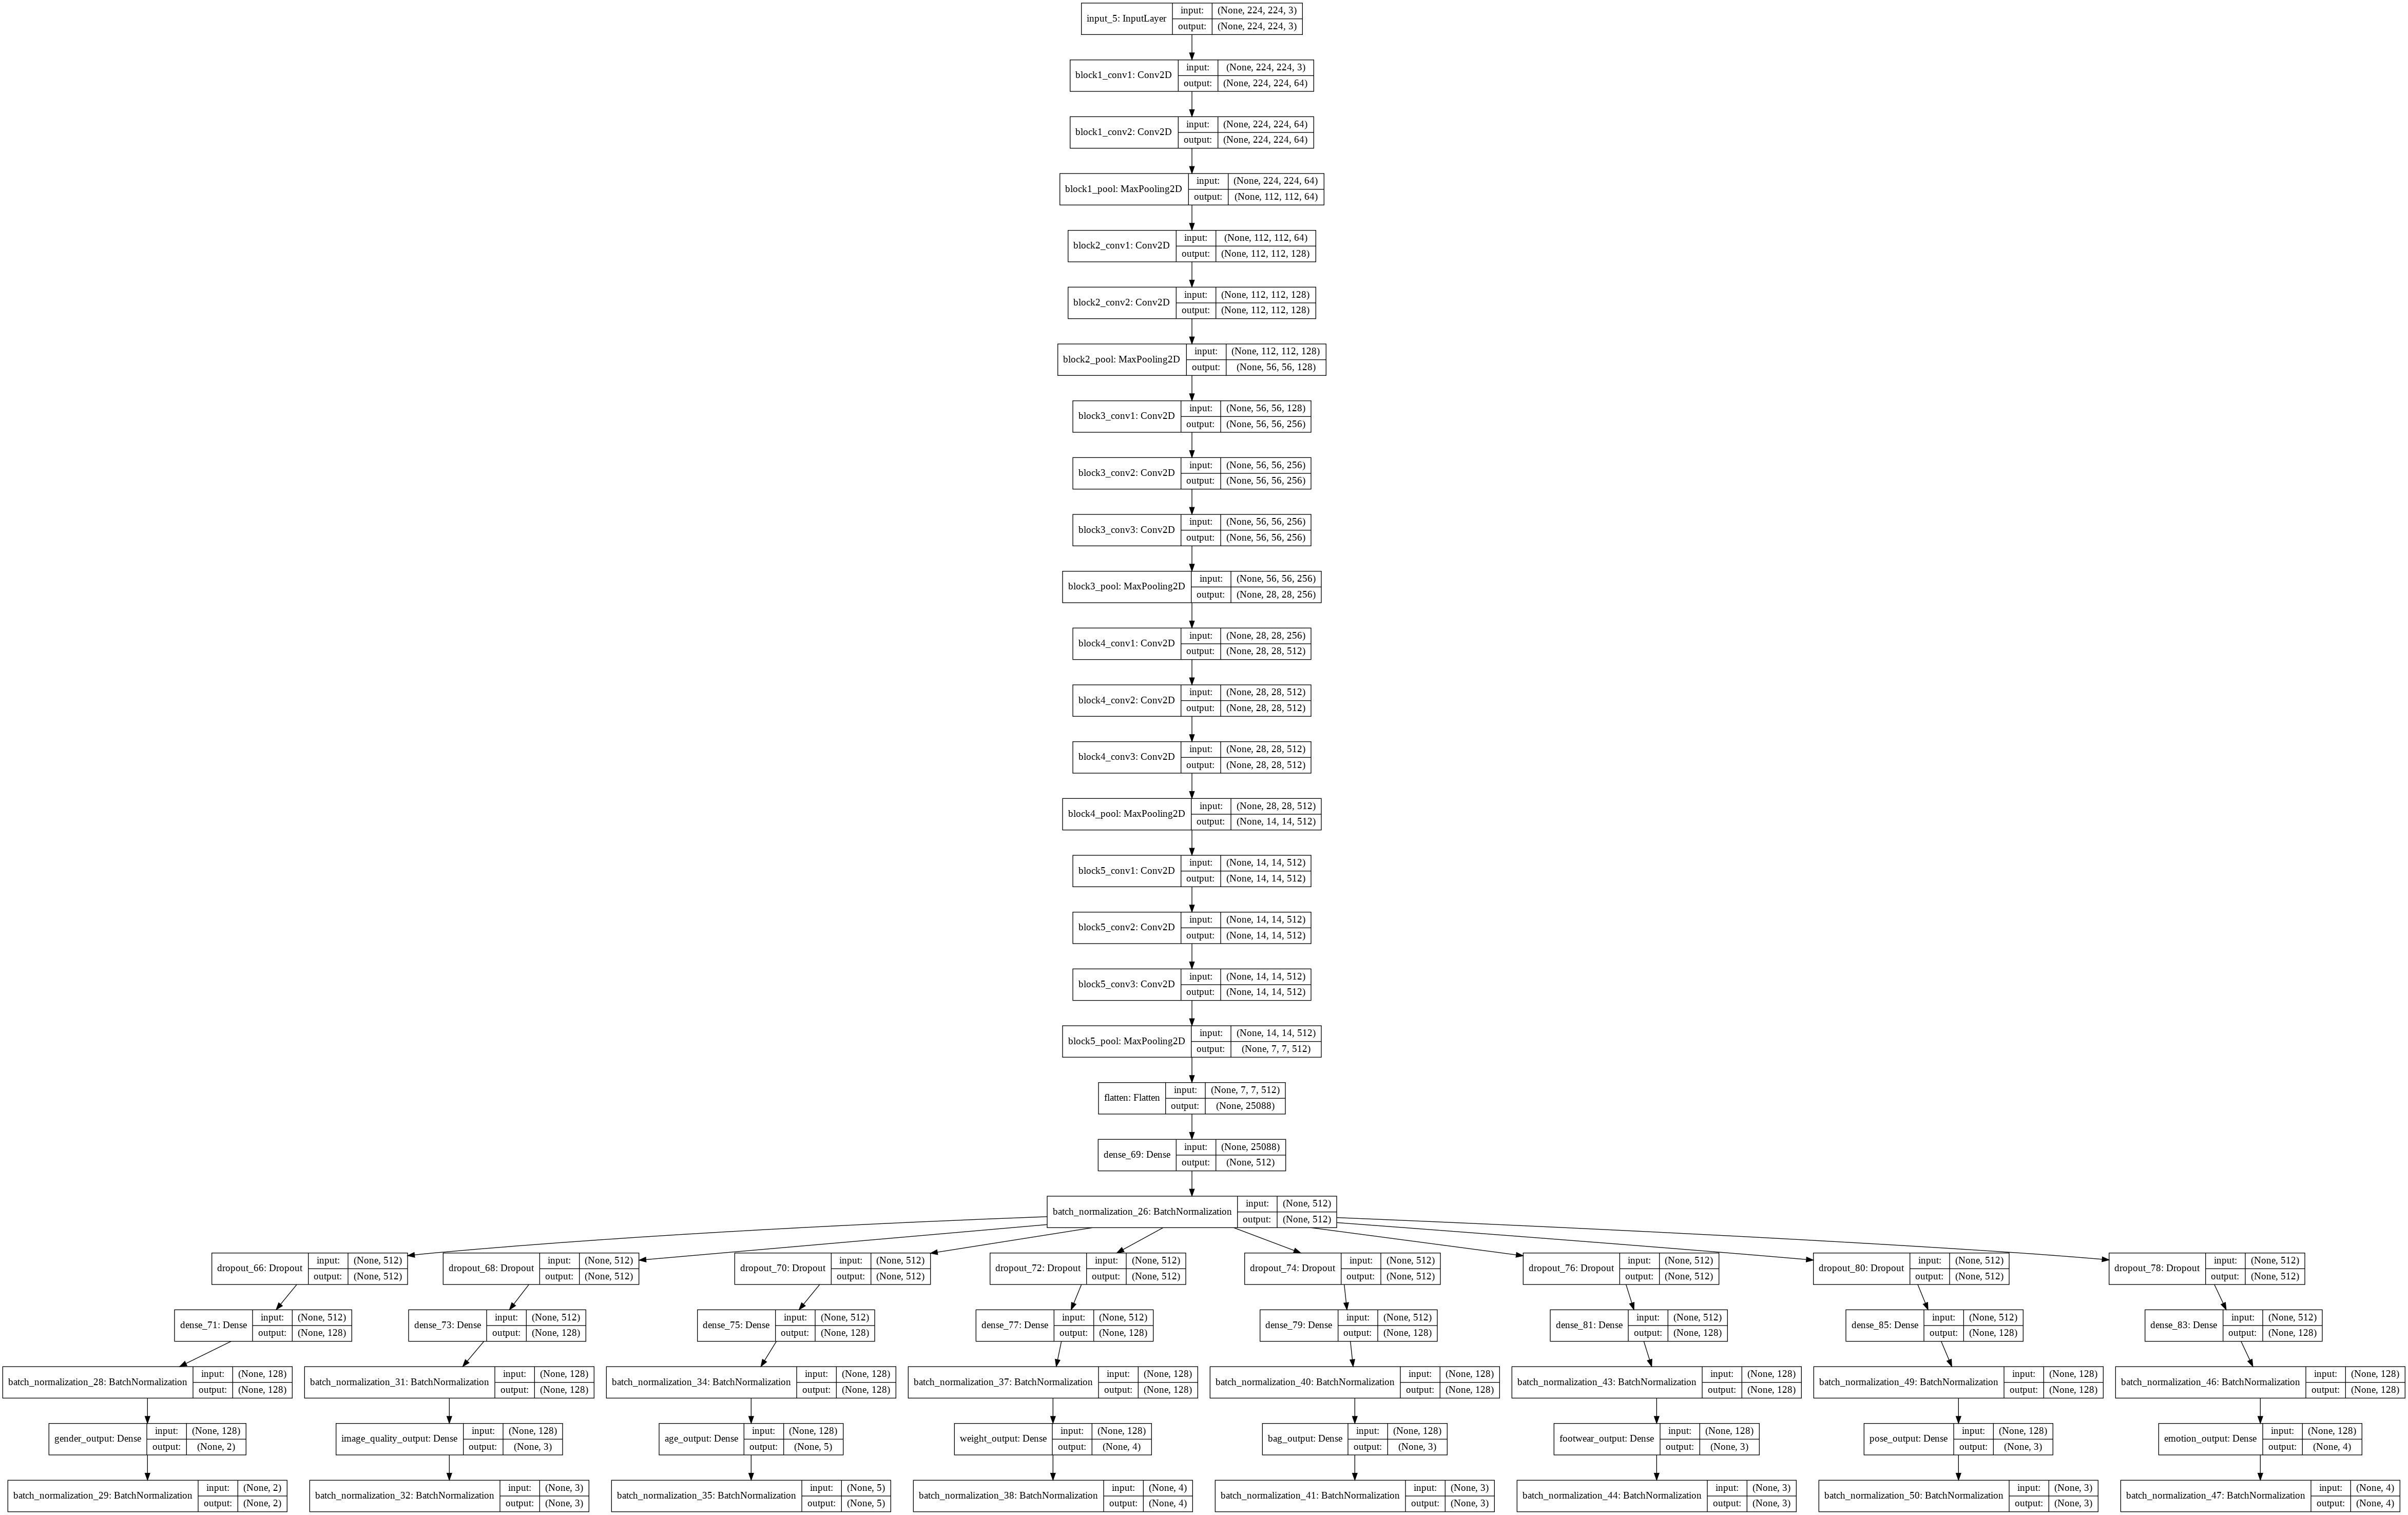

In [0]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)